# September 24 - EresNet training

In [6]:
# Imports
import sys
import os
import time
import math

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [7]:
# Fix the colour scheme for each particle type
color_dict = {"gamma":"red", "e":"blue", "mu":"green"}

# Fix the numpy seed
np.random.seed(42)

## Plot the training of the classifier using the training logs

In [8]:
# Plot model performance over the training iterations
def plot_training(log_paths, model_names, model_color_dict, downsample_interval=None, legend_loc=(0.8,0.5), show_plot=False, save_path=None):
    """
    plot_training_loss(training_directories=None, model_names=None, show_plot=False, save_path=None)
                           
    Purpose : Plot the training loss for various models for visual comparison
    
    Args: log_paths           ... List contatining the absolute path to the .csv log files
                                  Type : str
          model_names         ... List of the tring model name
                                  Type : str
          model_color_dict    ... Dictionary with the model_names as keys and
                                  the corresponding colors as values
          downsample_interval ... Downsample interval to smoothen the results,
                                  Type : int
          legend_loc          ... Location of where to put the legend on the plot
                                  Type : tuple
                                  Format : (x_pos, y_pos), 0 <= x_pos <= 1, 0 <= y_pos <= 1
          show_plot[optional] ... Boolean to determine whether to show the plot
                                  Type : Boolean
          save_path[optional] ... Absolute path to save the plot to
                                  Type : str
    """
    
    # Assertions
    assert log_paths is not None
    assert model_names is not None
    assert model_color_dict is not None
    assert len(log_paths) == len(model_names)
    assert len(model_names) == len(model_color_dict.keys())
    
    # Extract the values stored in the .csv log files
    epoch_values = []
    loss_values = []
    acc_values = []
    
    true_epoch_values = []
    true_loss_values = []
    true_acc_values = []
    
    # Iterate over the list of log files provided
    for log_path in log_paths:
        if(os.path.exists(log_path)):
            log_df = pd.read_csv(log_path, usecols=["epoch", "loss", "accuracy"])
            
            # Downsample the epoch and training loss values w.r.t. the downsample interval
            curr_epoch_values = log_df["epoch"].values
            curr_loss_values  = log_df["loss"].values
            curr_acc_values = log_df["accuracy"].values
            
            # Downsample using the downsample interval
            
            true_epoch_values.append(curr_epoch_values)
            true_loss_values.append(curr_loss_values)
            true_acc_values.append(curr_acc_values)
                
            if downsample_interval is not None:
                curr_epoch_values_downsampled = []
                curr_loss_values_downsampled  = []
                curr_acc_values_downsampled  = []

                curr_epoch_list = []
                curr_loss_list = []
                curr_acc_list = []

                for i in range(1, len(curr_epoch_values)):

                    if(i%downsample_interval == 0):

                        # Downsample the values using the mean of the values for the current interval
                        curr_epoch_values_downsampled.append(sum(curr_epoch_list)/downsample_interval)
                        curr_loss_values_downsampled.append(sum(curr_loss_list)/downsample_interval)
                        curr_acc_values_downsampled.append(sum(curr_acc_list)/downsample_interval)
                        

                        # Reset the list for the next interval
                        curr_epoch_list = []
                        curr_loss_list = []
                        curr_acc_list = []
                    else:
                        # Add the values in the interval to the list
                        curr_epoch_list.append(curr_epoch_values[i])
                        curr_loss_list.append(curr_loss_values[i]) 
                        curr_acc_list.append(curr_acc_values[i]) 

                epoch_values.append(curr_epoch_values_downsampled)
                loss_values.append(curr_loss_values_downsampled)
                acc_values.append(curr_acc_values_downsampled)
        else:
            print("Error. log path {0} does not exist".format(log_path))
            
    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(32,18))
    ax2 = ax1.twinx()
    
    # Plot the values
    if downsample_interval is None:
        for i, model_name in enumerate(model_names):
            ax1.plot(true_epoch_values[i], true_loss_values[i], 
                     color=model_color_dict[model_name][0],
                     label= model_name + " loss")
            ax2.plot(true_epoch_values[i], true_acc_values[i],
                     color=model_color_dict[model_name][1],
                     label= model_name + " accuracy")
    else:
        for i, model_name in enumerate(model_names):
            ax1.plot(true_epoch_values[i], true_loss_values[i],
                     color=model_color_dict[model_name][0], alpha=0.3)
            ax1.plot(epoch_values[i], loss_values[i],
                     color=model_color_dict[model_name][0],
                     label= model_name + " loss", alpha=0.8, linewidth=1.5)
            ax2.plot(true_epoch_values[i], true_acc_values[i],
                     color=model_color_dict[model_name][1], alpha=0.3)
            ax2.plot(epoch_values[i], acc_values[i],
                     color=model_color_dict[model_name][1],
                     label= model_name + " accuracy", alpha=0.8, linewidth=1.5)
        
        
    # Setup plot characteristics
    ax1.tick_params(axis="x", labelsize=30)
    ax1.set_xlabel("Epoch", fontsize=30)
    
    ax1.set_ylabel("Loss", fontsize=30, color=model_color_dict[model_name][0])
    ax1.tick_params(axis="y", labelsize=30, colors=model_color_dict[model_name][0])

    ax2.set_ylabel("Accuracy", fontsize=30, color=model_color_dict[model_name][1])
    ax2.tick_params(axis="y", labelsize=30, colors=model_color_dict[model_name][1])
    
    ax1.grid(True)
    ax2.grid(True)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    lgd = plt.legend(lines1 + lines2, labels1 + labels2, prop={"size":30},
                     loc="upper right", bbox_to_anchor=(1.32, 1.0), frameon=True,
                     fancybox=True, shadow=True)
    
    plt.margins(0.2)
    
    if save_path is not None:
        plt.savefig(save_path, format='eps', dpi=300, bbox_extra_artists=(lgd))
    else:
        plt.show()

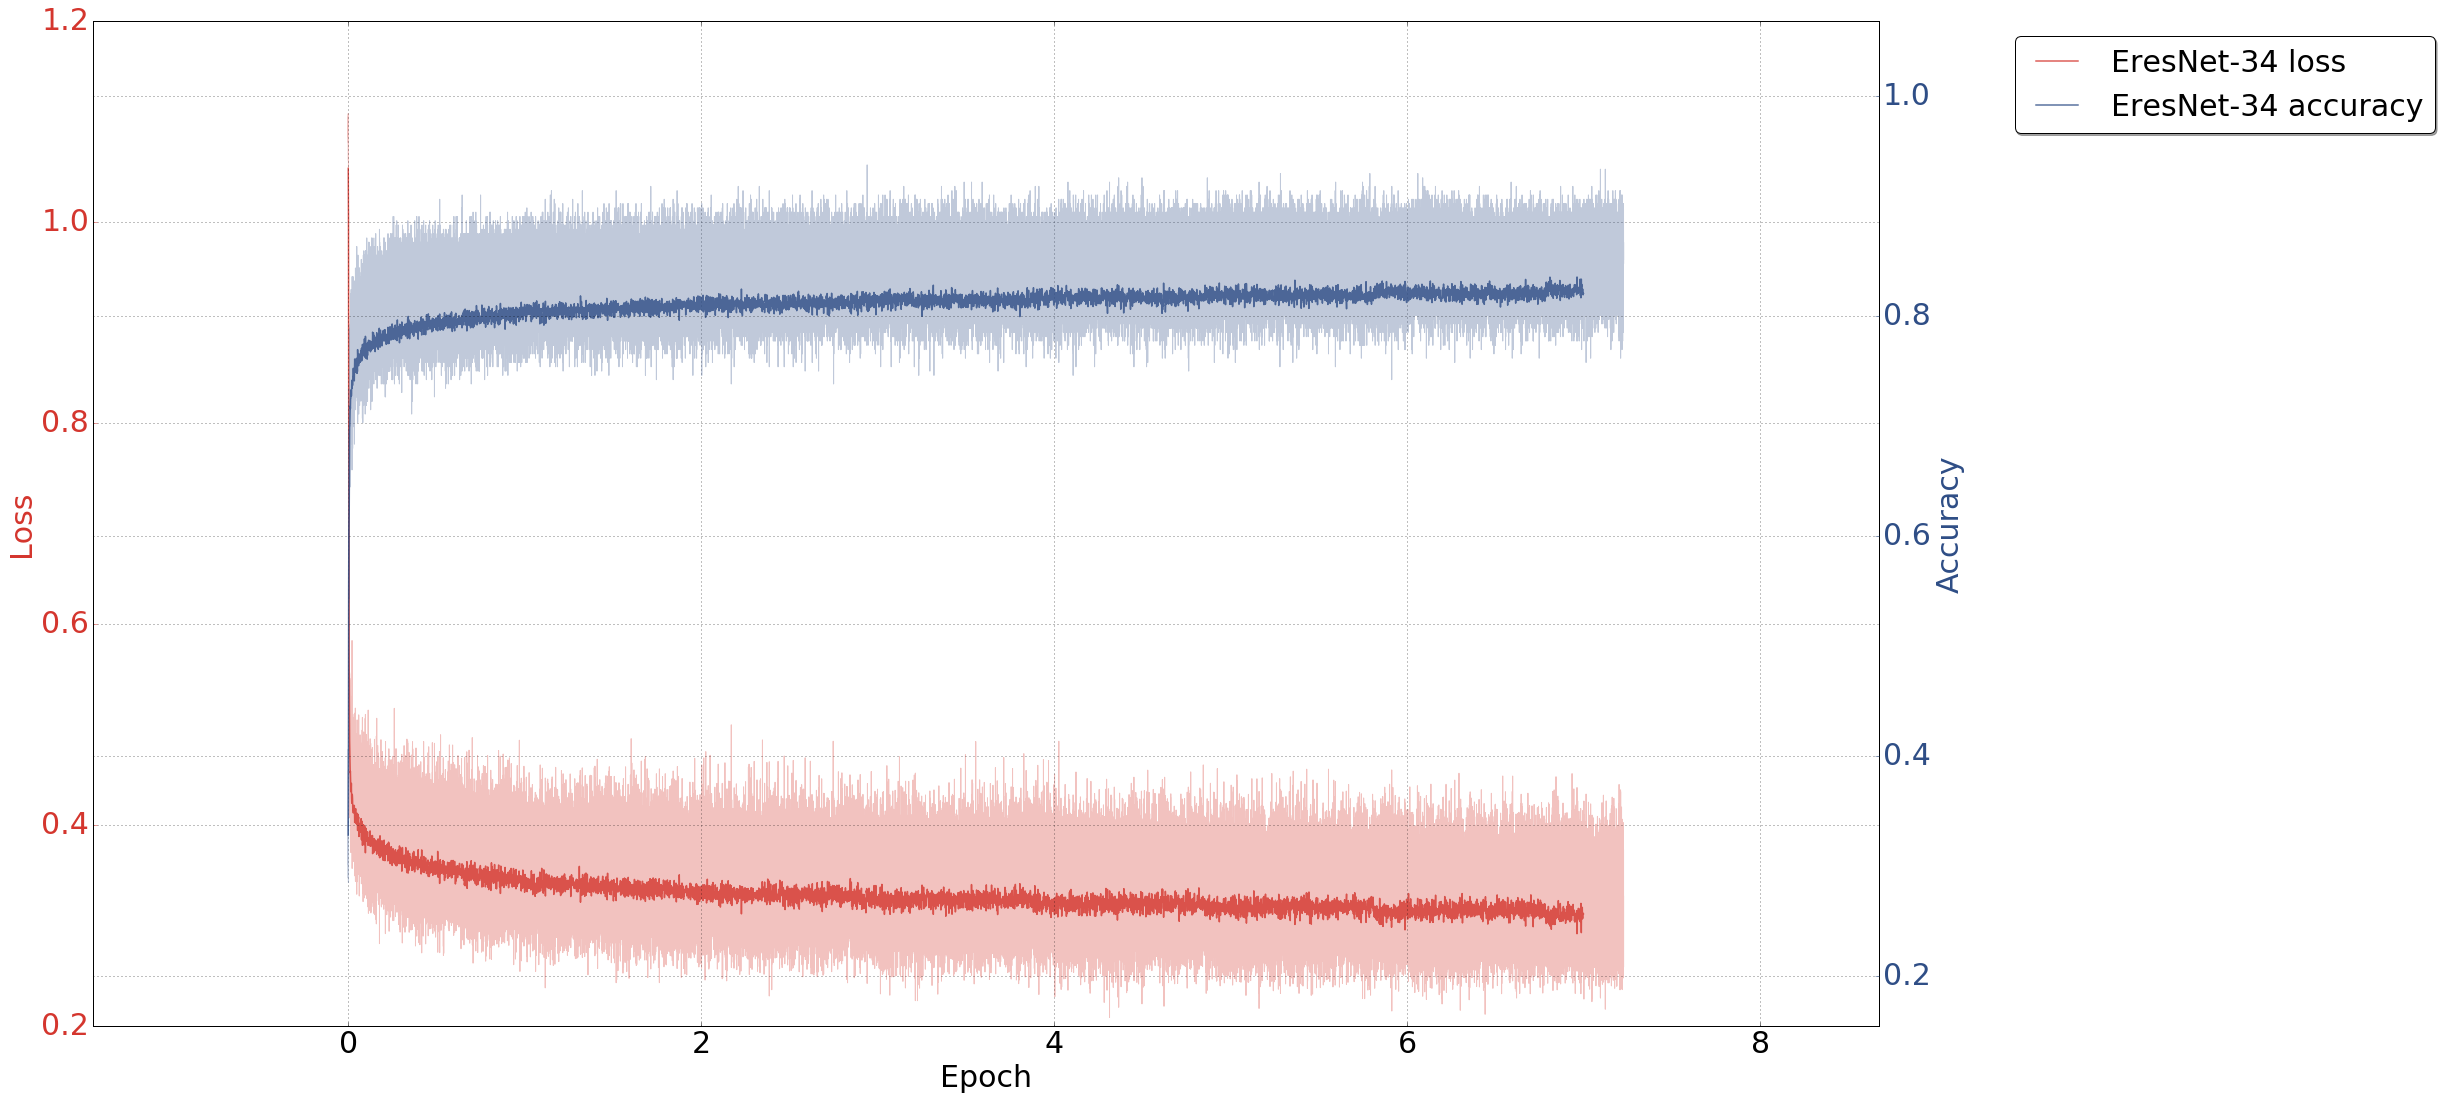

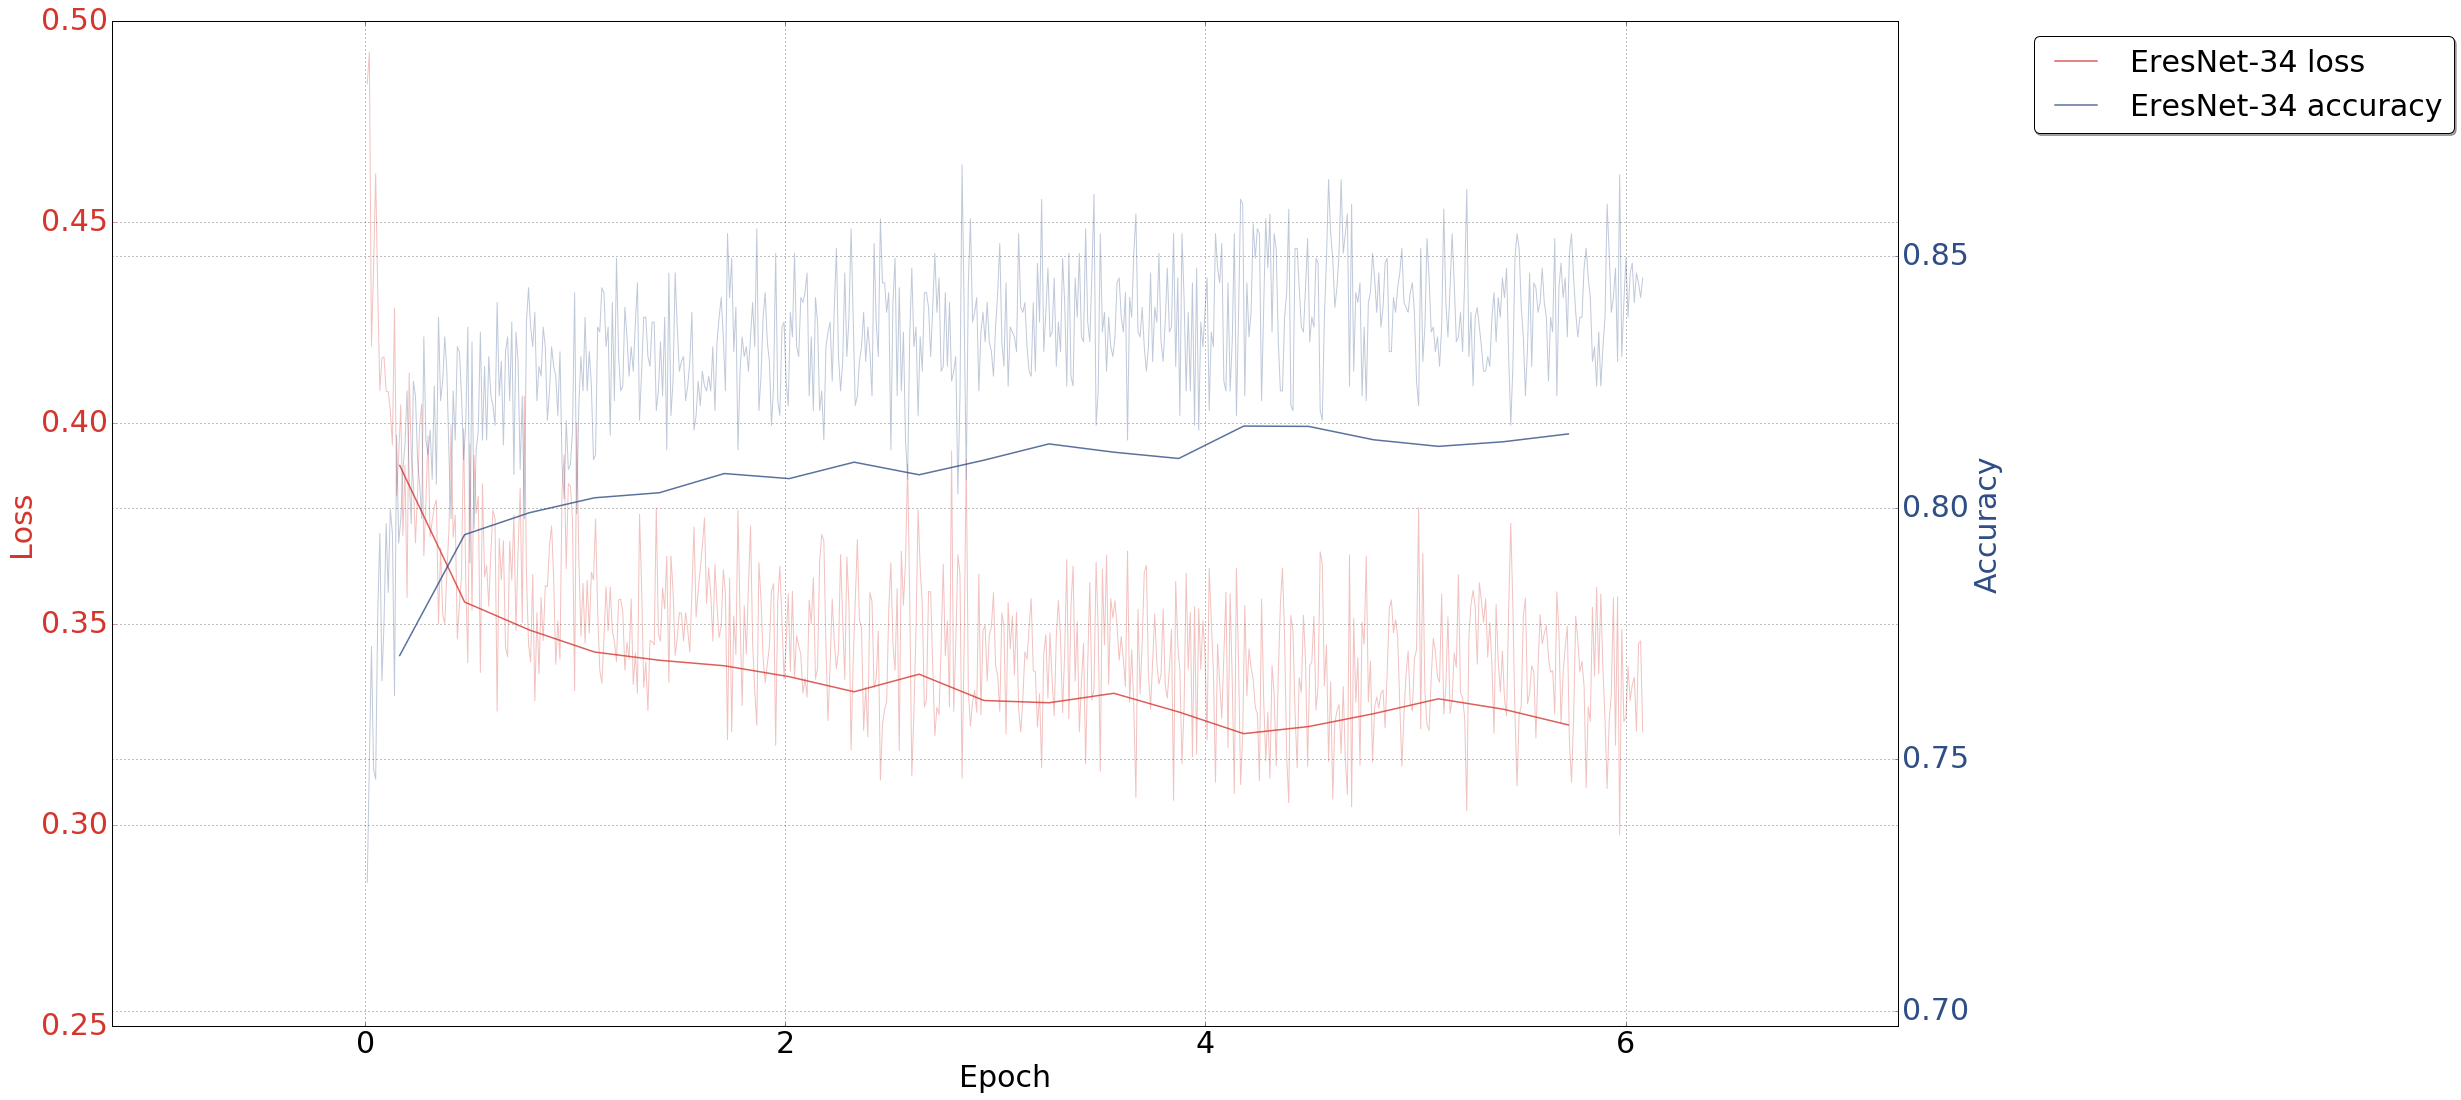

In [41]:
# Using the absolute path
run_ids = ["20190924_210536"]
model_ids = ["EresNet-34"]
dump_dirs = ["/home/akajal/WatChMaL/VAE/dumps/" + run_id + "/" for run_id in run_ids]
training_logs = [dump_dir + "log_train.csv" for dump_dir in dump_dirs]
val_logs = [dump_dir + "log_val.csv" for dump_dir in dump_dirs]

local_color_dict = {key:[np.random.rand(3,),np.random.rand(3,)] for key in model_ids}

# Plot training log
plot_training(training_logs, model_ids, local_color_dict,
              downsample_interval=32, show_plot=True)

# Plot validation log
plot_training(val_logs, model_ids, local_color_dict,
              downsample_interval=32, show_plot=True)

## Plot the performance of the using the AUC scores

In [37]:
# Plot the ROC curve for one vs another class
def plot_new_ROC(softmaxes, labels, energies, softmax_index_dict, label_0, label_1, 
                 min_energy=0, max_energy=1500, show_plot=False, save_path=None):
    
    assert softmaxes is not None
    assert labels is not None
    assert softmax_index_dict  is not None
    assert softmaxes.shape[0] == labels.shape[0]
    assert label_0 in softmax_index_dict.keys()
    assert label_1 in softmax_index_dict.keys()
    
    #------------------------------------------------------------------------
    # Create a boolean map to select events in the user-defined energy range
    #------------------------------------------------------------------------
    
    energy_slice_map = [False for i in range(len(energies))]
    
    for i in range(len(energies)):
        if(energies[i] >= min_energy and energies[i] < max_energy):
                energy_slice_map[i] = True
                
    curr_softmax = softmaxes[energy_slice_map]
    curr_labels = labels[energy_slice_map]
    
    #------------------------------------------------------------------------
    # Extract the softmax and true label values for signal and background events
    #------------------------------------------------------------------------
    
    # Extract the useful softmax and labels from the input arrays
    softmax_0 = curr_softmax[curr_labels==softmax_index_dict[label_0]]
    labels_0 = curr_labels[curr_labels==softmax_index_dict[label_0]] 
    
    softmax_1 = curr_softmax[curr_labels==softmax_index_dict[label_1]]
    labels_1 = curr_labels[curr_labels==softmax_index_dict[label_1]]
    
    # Add the two arrays
    softmax = np.concatenate((softmax_0, softmax_1), axis=0)
    labels = np.concatenate((labels_0, labels_1), axis=0)

    #------------------------------------------------------------------------
    # Compute the ROC curve and the AUC for class corresponding to label 0
    #------------------------------------------------------------------------
    
    fpr, tpr, threshold = roc_curve(labels, softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])
    roc_auc = auc(fpr, tpr)
    
    tnr = []
    for i in fpr:
        tnr.append(1/i) if i != 0 else tnr.append(1/1e-4)
    
    if show_plot or save_path is not None:
        
        # TNR vs TPR plot
        fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
        ax.tick_params(axis="both", labelsize=20)

        ax.plot(tpr, tnr, color=color_dict[label_0],
                 label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=color_dict[label_0])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, tnr):
            xy = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)
        
        plt.yscale("log")

        ax.set_title(r"${0} \leq E < {1}$".format(round(min_energy,2), round(max_energy,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        
    if save_path is not None:
        plt.savefig(save_path)
    
    if show_plot:
        plt.show()
        
    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

## ResNet-34 at epoch = 6.0 using the best validation model

In [38]:
num_samples = [9000000]

dumps = ["20190925_101052"]

dump_dir = "/home/akajal/WatChMaL/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"
softmax_index_dict = {"gamma":0, "e":1, "mu":2}

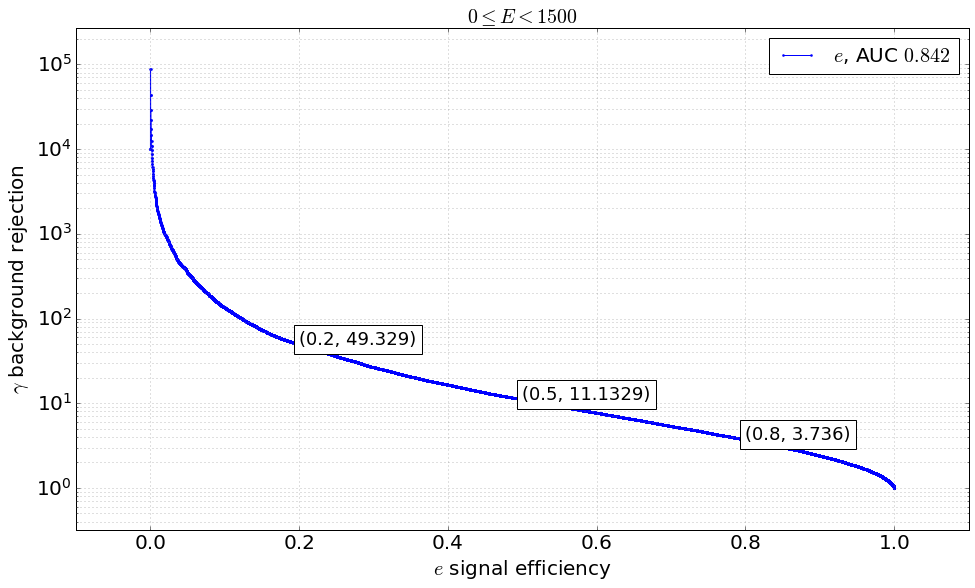

In [39]:
for num_sample, dump in zip(num_samples, dumps):
    
    test_dump_path = dump_dir + dump + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    roc_metrics = plot_new_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=0,
                               max_energy=1500, show_plot=True)